# Causal ML, Uplift Modeling Part 1

## Import Libraries & Data

In [104]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklift.metrics import qini_auc_score, qini_curve
# from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_hillstrom # our dataset!
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
from causalml.metrics import auuc_score, qini_score, get_cumgain
import seaborn as sns
import shap
import statsmodels.api as sm

In [2]:
# Load Hillstrom dataset
def load_hillstrom(target,print_info=True):
    dataset = fetch_hillstrom(target_col=target)
    df = dataset.data
    # Segment has 3 options, womens email, mens email and no email, so we can create 'treatment' by choosing one of the two treatments here
    df['segment'] = dataset.treatment
    # There are 3 outcomes, visit, conversion and spend, we can choose one of them as our target
    df[target] = dataset.target
    if print_info:
        print("Show me the top of the dataset\n")
        print(df.head())
        print("\n\n\n")
        print("Are there any null values in this dataframe?\n")
        print(df.isna().sum())
        print("\n\n\n")
        print("What does the dataframe look like? What datatypes are the features?\n")
        print(df.info())
    return df

data = load_hillstrom(target='visit')
df = data.copy()

Show me the top of the dataset

   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web   
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web   
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web   
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web   

         segment  visit  
0  Womens E-Mail      0  
1      No E-Mail      0  
2  Womens E-Mail      0  
3    Mens E-Mail      0  
4  Womens E-Mail      0  




Are there any null values in this dataframe?

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64




What does the dataframe look like? What datatypes are 

In [3]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


## Explore Data

In [4]:
# The treatment
df['segment'].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [5]:
# Let's just use men's email first and create a treatment variable to 1/0 the treatment/control
df = df.loc[df['segment'].isin(['Mens E-Mail','No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})
df['treatment'].value_counts(normalize=True)

treatment
1    0.500012
0    0.499988
Name: proportion, dtype: float64

In [6]:
# This dataset has visit, conversion, and revenue as the target variables, we are going to use visit as the target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

target
0    36457
1     6156
Name: count, dtype: int64

In [7]:
# Customer purchased mens merchandise in the past year
df['mens'].value_counts()

mens
1    23526
0    19087
Name: count, dtype: int64

In [8]:
# Customer purchased womens merchandise in the past year
df['womens'].value_counts()

womens
1    23417
0    19196
Name: count, dtype: int64

In [9]:
# Only a few customers purchased from both mens and womens merch in the past year
df.groupby(['mens','womens']).size()

mens  womens
0     1         19087
1     0         19196
      1          4330
dtype: int64

In [10]:
# segments for TTM spend
df['history_segment'].value_counts()

history_segment
1) $0 - $100        15336
2) $100 - $200       9527
3) $200 - $350       8134
4) $350 - $500       4221
5) $500 - $750       3249
6) $750 - $1,000     1266
7) $1,000 +           880
Name: count, dtype: int64

In [11]:
# Define conditions and corresponding values
conditions = [
    df['history_segment'].isin(['1) $0 - $100', '2) $100 - $200']),
    df['history_segment'].isin(['3) $200 - $350', '4) $350 - $500', '5) $500 - $750'])
]
choices = ['low', 'medium']

# Apply conditions to create the new column
df['history_bins'] = np.select(conditions, choices, default='high')

df['history_bins'].value_counts()


history_bins
low       24863
medium    15604
high       2146
Name: count, dtype: int64

In [12]:
df.groupby('history_bins')['target'].mean()

history_bins
high      0.198509
low       0.121546
medium    0.173545
Name: target, dtype: float64

In [13]:
# Actual TTM spend
df['history'].describe()

count    42613.000000
mean       241.859315
std        256.574723
min         29.990000
25%         64.500000
50%        157.000000
75%        325.210000
max       3345.930000
Name: history, dtype: float64

In [14]:
# Months since last purchase
df['recency'].value_counts()

recency
1     5934
2     5074
10    5022
9     4330
3     3899
4     3406
6     3048
5     2985
7     2720
8     2337
11    2316
12    1542
Name: count, dtype: int64

In [15]:
# New custome in past year
df['newbie'].value_counts()

newbie
1    21381
0    21232
Name: count, dtype: int64

In [16]:
# TTM purchase channels - must be an old dataset given the phone count
df['channel'].value_counts()

channel
Web             18863
Phone           18567
Multichannel     5183
Name: count, dtype: int64

In [17]:
# Classifies urban rural and suburban
df['zip_code'].value_counts()

zip_code
Surburban    19126
Urban        17105
Rural         6382
Name: count, dtype: int64

In [18]:
# Binarize the zip code and channel variables
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int)  # Encode categorical variable
# df = pd.get_dummies(df, columns=['history_segment'], drop_first=True, dtype=int)  # Encode categorical variable
df['recency_bins'] = np.where(df['recency'].between(1,4),'low',np.where(df['recency'].between(5,8),'medium','high'))
df = pd.get_dummies(df, columns=['recency_bins'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['history_bins'], drop_first=True, dtype=int)  # Encode categorical variable
df = df.drop(columns=['segment','visit','history','recency','history_segment']) # Drop unnecessary features

In [19]:
df = df.rename(columns={'history_segment_2) $100 - $200':'history_segment_100_200',
                        'history_segment_3) $200 - $350':'history_segment_200_350',
                        'history_segment_4) $350 - $500':'history_segment_350_500',
                        'history_segment_5) $500 - $750':'history_segment_500_750',
                        'history_segment_6) $750 - $1,000':'history_segment_750_1000',
                        'history_segment_7) $1,000 +':'history_segment_1000_plus'})

In [20]:
# One grand view of our final dataset! Looks ready for modeling.
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


In [21]:
# It appears everything is just about equal in terms of the treatment group and the control group for feature means, except the target which is ok
df.groupby('treatment').mean()

# Even if it wasn't, we could still run the model using the covariates as features, but would need to adjust for the imbalance in the treatment groups

,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
treatment,,,,,,,,,,,,
0,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923,0.429879,0.263682,0.584249,0.367033
1,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394,0.429624,0.256817,0.582672,0.365326


## Campaign Analysis

- Which e-mail campaign performed the best, the Mens version, or the Womens version?
- How much incremental sales per customer did the Mens version of the e-mail campaign drive? How much incremental sales per customer did the Womens version of the e-mail campaign drive?
- If you could only send an e-mail campaign to the best 10,000 customers, which customers would receive the e-mail campaign? Why?
- If you had to eliminate 10,000 customers from receiving an e-mail campaign, which customers would you suppress from the campaign? Why?
- Did the Mens version of the e-mail campaign perform different than the Womens version of the e-mail campaign, across various customer segments?
- Did the campaigns perform different when measured across different metrics, like Visitors, Conversion, and Total Spend?
- Did you observe any anomalies, or odd findings?
- Which audience would you target the Mens version to, and the Womens version to, given the results of the test? What data do you have to support your recommendation?

In [22]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


### Which e-mail campaign performed the best, the Mens version, or the Womens version?

In [23]:
data.groupby('segment')['visit'].value_counts(normalize=True).reset_index()

,segment,visit,proportion
0,Mens E-Mail,0,0.817243
1,Mens E-Mail,1,0.182757
2,No E-Mail,0,0.893833
3,No E-Mail,1,0.106167
4,Womens E-Mail,0,0.848600
5,Womens E-Mail,1,0.151400


In [24]:
mens = data.loc[data['segment']=='Mens E-Mail']['visit'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['visit'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['visit'].mean()

mens_lift = (mens - no_email) / no_email
womens_lift = (womens - no_email) / no_email

print(f"Men's email lift: {mens_lift*100}")
print(f"Women's email lift: {womens_lift*100}")

Men's email lift: 72.1404616781399
Women's email lift: 42.60550702669102


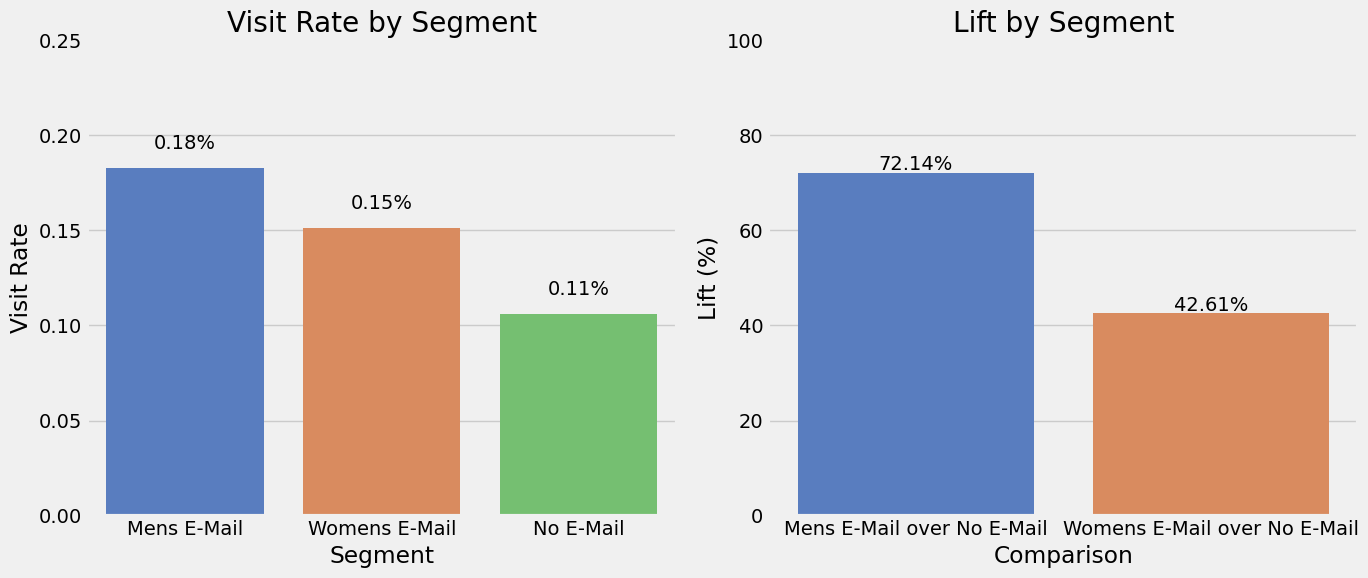

In [25]:
# Plot visit rates
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
visit_rates = pd.DataFrame({
    'Segment': ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail'],
    'Visit Rate': [mens, womens, no_email]
})
sns.barplot(x='Segment', y='Visit Rate', data=visit_rates, palette='muted', hue='Segment', legend=False)
for index, value in enumerate(visit_rates['Visit Rate']):
    plt.text(index, value + 0.01, f'{value:.2f}%', ha='center')
plt.xlabel('Segment')
plt.ylabel('Visit Rate')
plt.title('Visit Rate by Segment')
plt.ylim(0, 0.25)  # Set y-axis limit for lifts

# Plot lifts
plt.subplot(1, 2, 2)
lifts = pd.DataFrame({
    'Comparison': ['Mens E-Mail over No E-Mail', 'Womens E-Mail over No E-Mail'],
    'Lift (%)': [mens_lift * 100, womens_lift * 100]
})
sns.barplot(x='Comparison', y='Lift (%)', data=lifts, palette='muted', hue='Comparison', legend=False)
for index, value in enumerate(lifts['Lift (%)']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.xlabel('Comparison')
plt.ylabel('Lift (%)')
plt.title('Lift by Segment')
plt.ylim(0, 100)  # Set y-axis limit for lifts

plt.tight_layout()
plt.show()

In [26]:
data = load_hillstrom(target='conversion',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['conversion'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['conversion'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['conversion'].mean()

mens_lift = (mens - no_email) / no_email
womens_lift = (womens - no_email) / no_email

print(f"Men's email lift: {mens_lift*100}")
print(f"Women's email lift: {womens_lift*100}")

Men's email lift: 118.84218762863279
Women's email lift: 54.33130436982172


In [27]:
print(mens)

0.01253109306800582


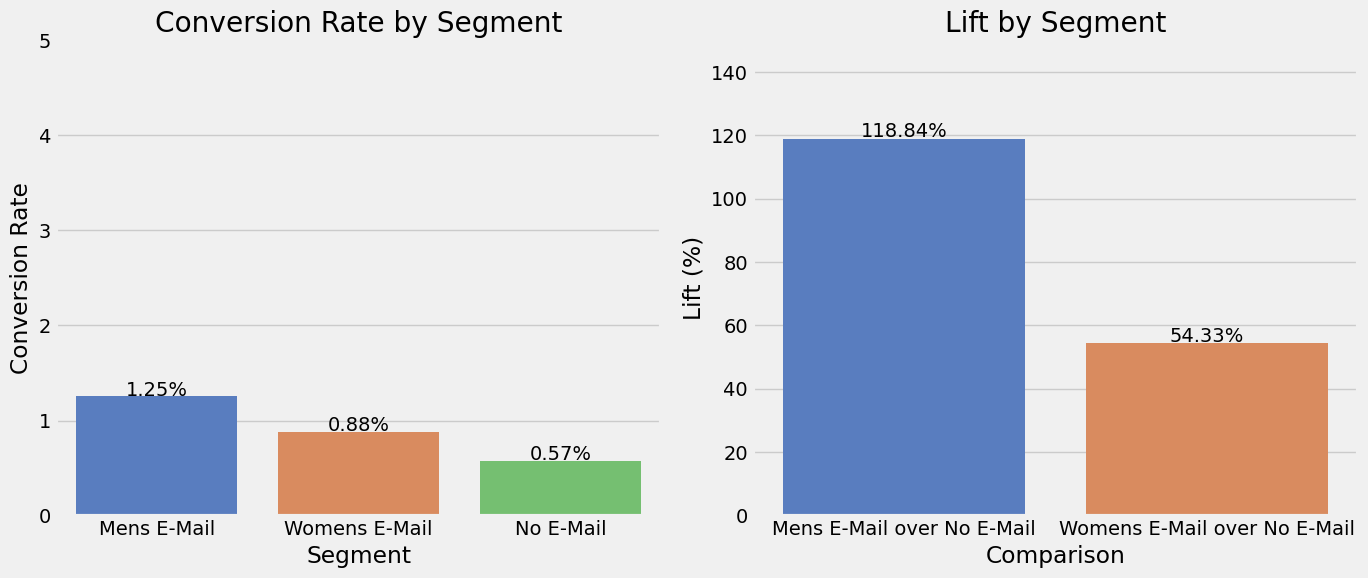

In [28]:
# Plot visit rates
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
visit_rates = pd.DataFrame({
    'Segment': ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail'],
    'Conversion Rate': [mens, womens, no_email]
})
visit_rates['Conversion Rate'] = visit_rates['Conversion Rate']*100
sns.barplot(x='Segment', y='Conversion Rate', data=visit_rates, palette='muted', hue='Segment', legend=False)
for index, value in enumerate(visit_rates['Conversion Rate']):
    plt.text(index, value + 0.01, f'{value:.2f}%', ha='center')
plt.xlabel('Segment')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Segment')
plt.ylim(0, 5)  # Set y-axis limit for lifts

# Plot lifts
plt.subplot(1, 2, 2)
lifts = pd.DataFrame({
    'Comparison': ['Mens E-Mail over No E-Mail', 'Womens E-Mail over No E-Mail'],
    'Lift (%)': [mens_lift * 100, womens_lift * 100]
})
sns.barplot(x='Comparison', y='Lift (%)', data=lifts, palette='muted', hue='Comparison', legend=False)
for index, value in enumerate(lifts['Lift (%)']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.xlabel('Comparison')
plt.ylabel('Lift (%)')
plt.title('Lift by Segment')
plt.ylim(0, 150)  # Set y-axis limit for lifts

plt.tight_layout()
plt.show()

In [29]:
data = load_hillstrom(target='spend',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['spend'].mean()

mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: {mens_lift}")
print(f"Women's email lift: {womens_lift}")

Men's email lift: 0.7698271558945367
Women's email lift: 0.4244122159365966


The mens email performed better in visits, conversion, and spend.

### How much incremental sales per customer did the Mens version of the e-mail campaign drive? How much incremental sales per customer did the Womens version of the e-mail campaign drive?

In [30]:
data = load_hillstrom(target='spend',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['spend'].mean()

mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: {mens_lift}")
print(f"Women's email lift: {womens_lift}")

Men's email lift: 0.7698271558945367
Women's email lift: 0.4244122159365966


In [31]:
data = load_hillstrom(target='spend',print_info=False)
# data = data.loc[data['spend']>0]
# Calculate spend means
mens = data.loc[data['segment'] == 'Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment'] == 'Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment'] == 'No E-Mail']['spend'].mean()

# Calculate lifts
mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: ${mens_lift:.2f}")
print(f"Women's email lift: ${womens_lift:.2f}")

Men's email lift: $0.77
Women's email lift: $0.42


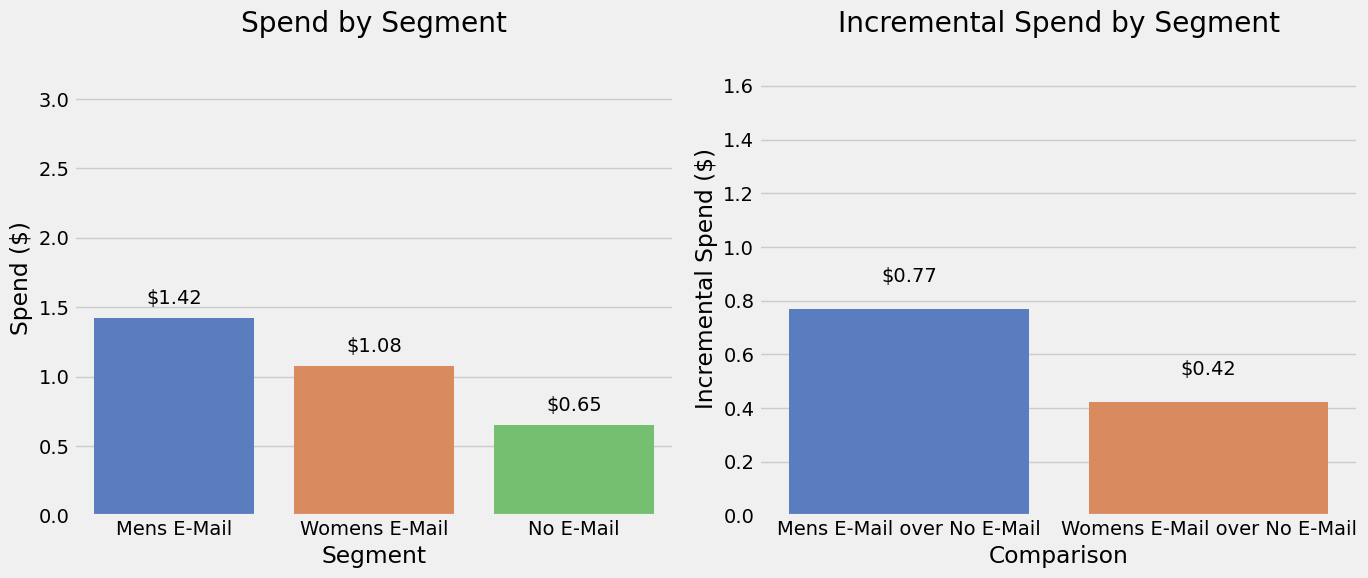

In [32]:
# Plot spend rates
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
spend_rates = pd.DataFrame({
    'Segment': ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail'],
    'Spend ($)': [mens, womens, no_email]
})
sns.barplot(x='Segment', y='Spend ($)', data=spend_rates, palette='muted', hue='Segment', legend=False)
for index, value in enumerate(spend_rates['Spend ($)']):
    plt.text(index, value + 0.1, f'${value:.2f}', ha='center')
plt.xlabel('Segment')
plt.ylabel('Spend ($)')
plt.title('Spend by Segment')
plt.ylim(0, max(spend_rates['Spend ($)']) + 2)  # Set y-axis limit for spend

# Plot lifts
plt.subplot(1, 2, 2)
lifts = pd.DataFrame({
    'Comparison': ['Mens E-Mail over No E-Mail', 'Womens E-Mail over No E-Mail'],
    'Incremental Spend ($)': [mens_lift, womens_lift]
})
sns.barplot(x='Comparison', y='Incremental Spend ($)', data=lifts, palette='muted', hue='Comparison', legend=False)
for index, value in enumerate(lifts['Incremental Spend ($)']):
    plt.text(index, value + 0.1, f'${value:.2f}', ha='center')
plt.xlabel('Comparison')
plt.ylabel('Incremental Spend ($)')
plt.title('Incremental Spend by Segment')
plt.ylim(0, max(lifts['Incremental Spend ($)']) + 1)  # Set y-axis limit for incremental spend

plt.tight_layout()
plt.show()

For those who purchased, the Women's email cusotmers spent them most, followed by the no email customers, then the men's email customers.
It appears that the conversion rate lift for the men is high enough to offset any decrease in spend per customer.

## Feature Engineering to improve model

In [33]:
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


### Difference in visit rates given treatment and given control in different areas of the feature

In [34]:
for i in df.columns.to_list():
    if i not in ['treatment','target']:
        data = df.groupby(['treatment',i]).agg({'target':'mean'}).reset_index()
        diff_on = data.loc[(data['treatment']==1)&(data[i]==1)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==1)]['target'].values[0]
        diff_off = data.loc[(data['treatment']==1)&(data[i]==0)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==0)]['target'].values[0]
        # print(data)
        # print(diff_on)
        # print(diff_off)
        print(f"Feature {i} has a difference in means of {diff_on-diff_off:.2f}")
        print(f"Feature {i} has a treatment effect of {(diff_on-diff_off)/diff_off*100:.2f}%")

Feature mens has a difference in means of 0.01
Feature mens has a treatment effect of 15.57%
Feature womens has a difference in means of 0.01
Feature womens has a treatment effect of 19.38%
Feature newbie has a difference in means of -0.00
Feature newbie has a treatment effect of -3.25%
Feature zip_code_Surburban has a difference in means of -0.00
Feature zip_code_Surburban has a treatment effect of -5.02%
Feature zip_code_Urban has a difference in means of 0.01
Feature zip_code_Urban has a treatment effect of 6.81%
Feature channel_Phone has a difference in means of -0.00
Feature channel_Phone has a treatment effect of -1.94%
Feature channel_Web has a difference in means of -0.00
Feature channel_Web has a treatment effect of -2.11%
Feature recency_bins_low has a difference in means of 0.01
Feature recency_bins_low has a treatment effect of 20.23%
Feature recency_bins_medium has a difference in means of -0.01
Feature recency_bins_medium has a treatment effect of -17.27%
Feature history_

### Variable Means by treatment and target

In [35]:
for i in df.columns.to_list():
    print(df.groupby(['treatment','target']).agg({i:'mean'}))

                      mens
treatment target          
0         0       0.548047
          1       0.596817
1         0       0.541951
          1       0.591166
                    womens
treatment target          
0         0       0.544423
          1       0.574713
1         0       0.543847
          1       0.585259
                    newbie
treatment target          
0         0       0.517328
          1       0.372679
1         0       0.519095
          1       0.422958
                  treatment
treatment target           
0         0             0.0
          1             0.0
1         0             1.0
          1             1.0
                  target
treatment target        
0         0          0.0
          1          1.0
1         0          0.0
          1          1.0
                  zip_code_Surburban
treatment target                    
0         0                 0.455367
          1                 0.421309
1         0                 0.451042
          1

### Graph out mean target by treatment and feature

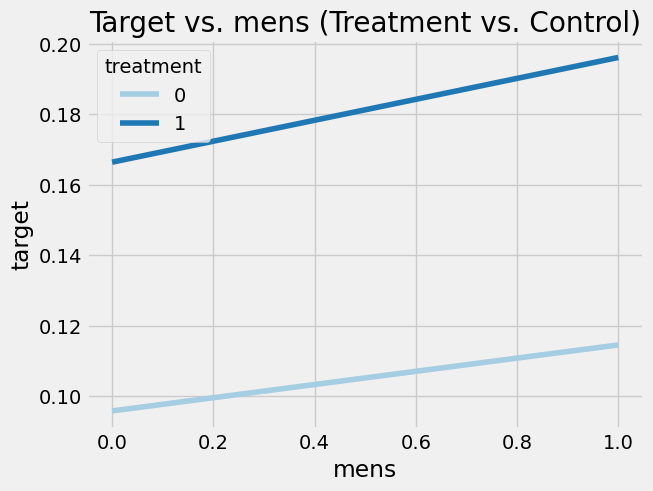

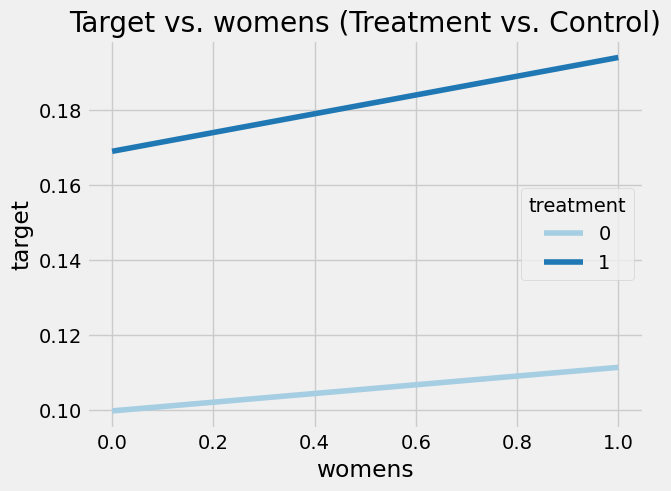

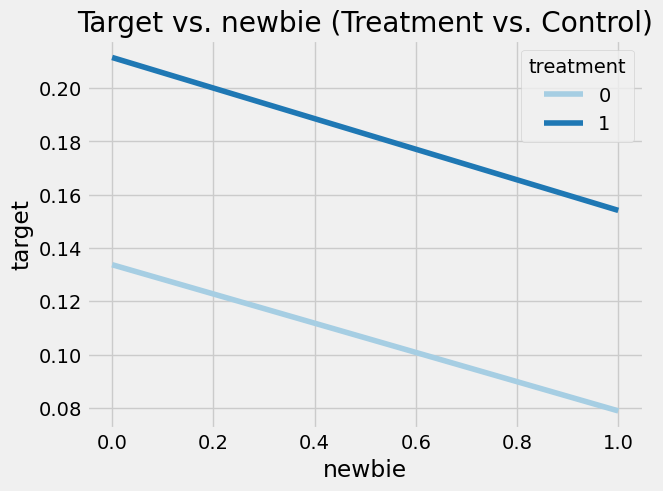

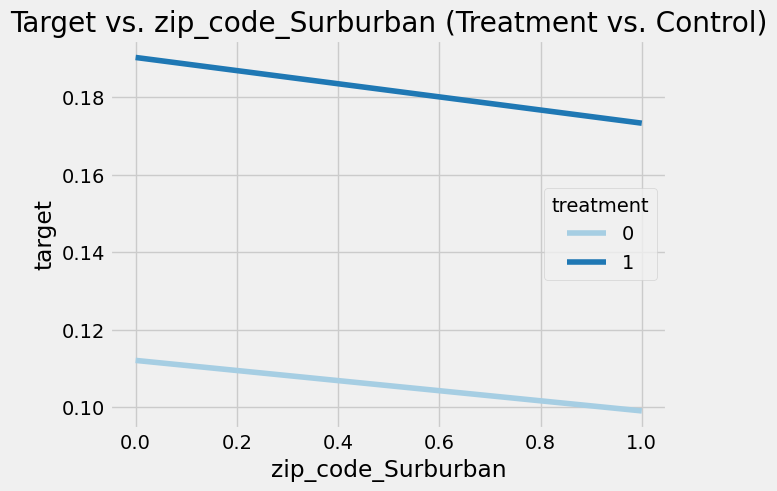

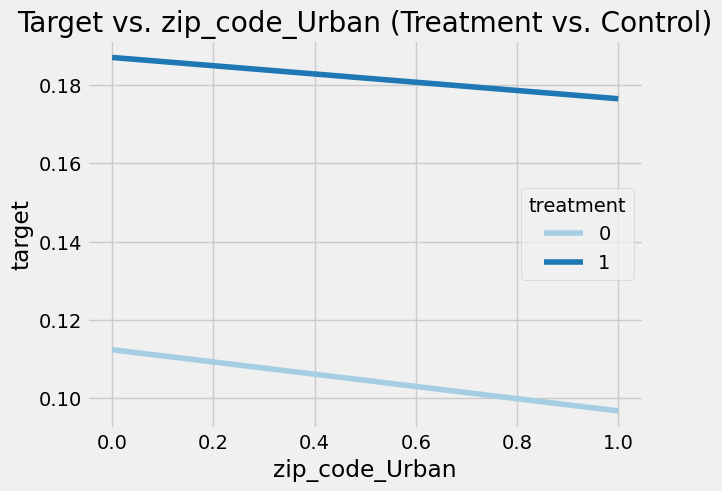

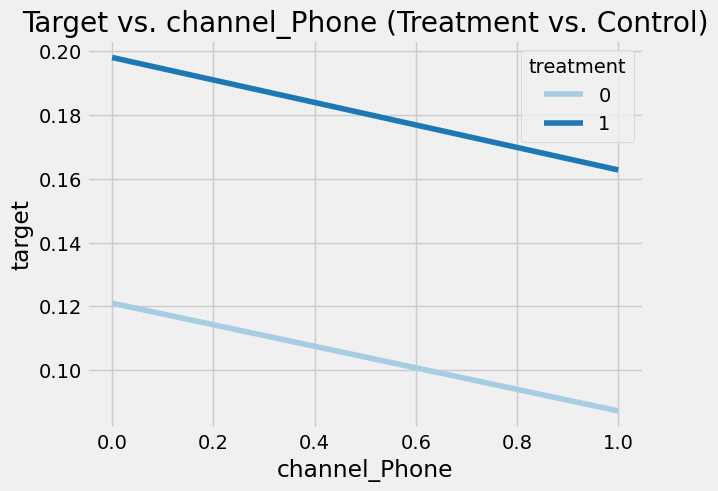

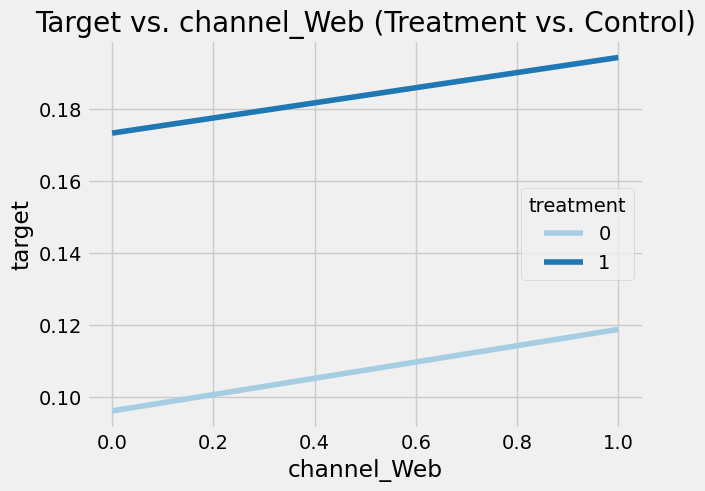

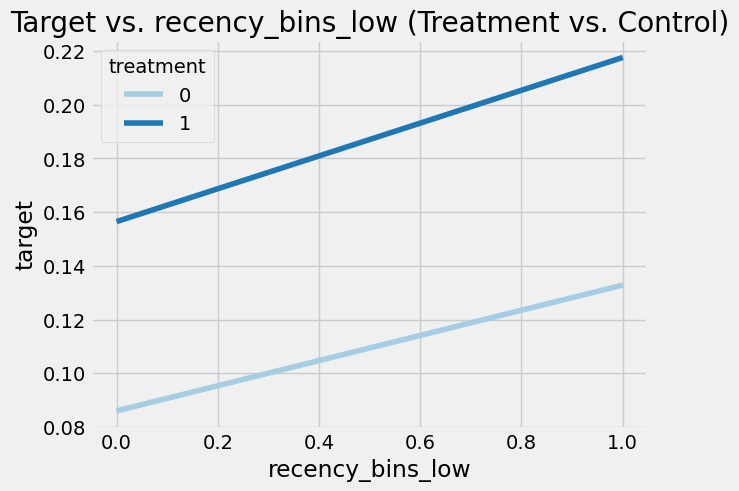

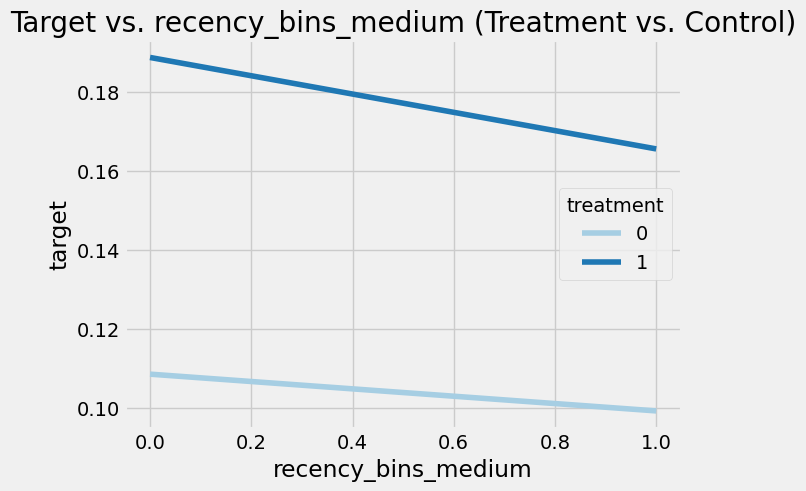

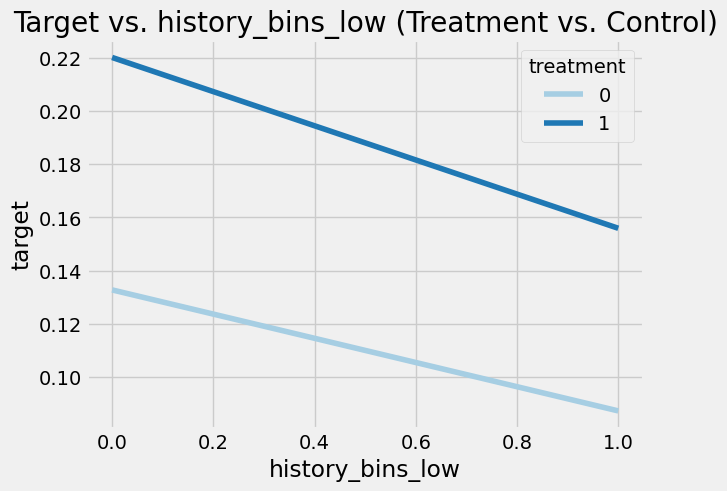

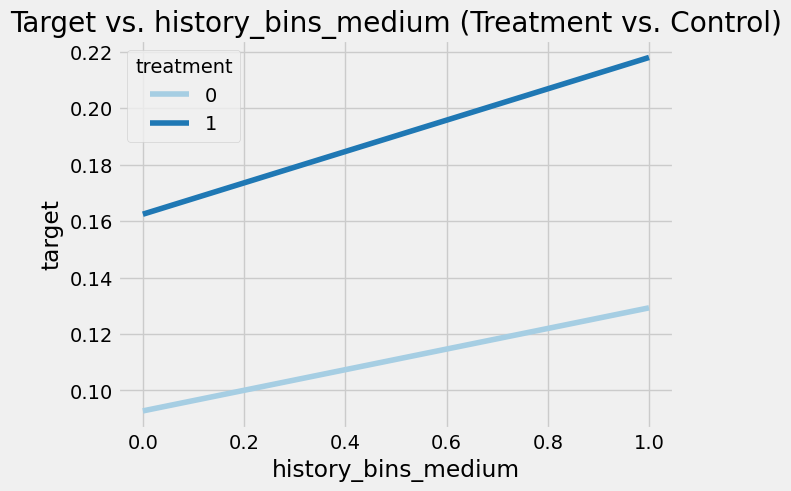

In [36]:
for i in df.columns.to_list():
    if i not in ['treatment','target']:
        # Calculate mean outcomes by recency
        summary = df.groupby(['treatment', i]).agg({'target': 'mean'}).reset_index()

        # Plot outcomes for treatment and control groups
        sns.lineplot(data=summary, x=i, y='target', hue='treatment')
        plt.title(f'Target vs. {i} (Treatment vs. Control)')
        plt.show()

### Create interaction features and test using logistic regression

In [37]:
# Create interaction features

# Hypothesis: Zip code urban will perform better than zip code rural or suburban given the treatment
df['zip_code_Urban_treatment'] = df['zip_code_Urban'] * df['treatment']
df['channel_Phone_treatment'] = df['channel_Phone'] * df['treatment']
df['history_bins_medium_treatment'] = df['history_bins_medium'] * df['treatment']
df['recency_bins_low_treatment'] = df['recency_bins_low'] * df['treatment']
df['newbie_mens'] = df['newbie'] * df['mens']
df['newbie_womens'] = df['newbie'] * df['womens']


# Final feature list
varlist = [
    'treatment',
    'mens',
    'womens',
    'newbie',
    'recency_bins_low',
    'recency_bins_medium',
    'history_bins_low',
    'history_bins_medium',
    'zip_code_Surburban',
	'zip_code_Urban',
	'channel_Phone',
    'channel_Web',

    # 'newbie_mens',
    # 'newbie_womens',

    # 'history_segment_100_200',
    # 'history_segment_200_350',
    # 'history_segment_350_500',
    # 'history_segment_500_750',
    # 'history_segment_750_1000',
    # 'history_segment_1000_plus',
    
    # 'zip_code_Urban_treatment',
    # 'channel_Phone_treatment',
    # 'history_bins_medium_treatment',
    # 'recency_bins_low_treatment',
]

df_updated = df[varlist + ['target']]

# run quick regression to see coefficients
sm.Logit(df_updated['target'], sm.add_constant(df_updated[varlist])).fit().summary()

# df_control = df_updated.loc[df_updated['treatment'] == 0]
# df_treatment = df_updated.loc[df_updated['treatment'] == 1]
# X_control = df_control[varlist]
# y_control = df_control['target']
# X_treatment = df_treatment[varlist]
# y_treatment = df_treatment['target']
# sm.Logit(y_control, sm.add_constant(X_control)).fit().summary()
# sm.Logit(y_treatment, sm.add_constant(X_treatment)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.392765
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                42613
Model:                          Logit   Df Residuals:                    42600
Method:                           MLE   Df Model:                           12
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                 0.04896
Time:                        10:44:34   Log-Likelihood:                -16737.
converged:                       True   LL-Null:                       -17598.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.2030      0.105    -21.061      0.000      -2.408      -1.998
treatment               0.6469      0.029     22.399      0.000       0.590       0.703
mens                    0.6588      0.047     14.146      0.000       0.568       0.750
womens                  0.6300      0.046     13.572      0.000       0.539       0.721
newbie                 -0.5727      0.030    -19.033      0.000      -0.632      -0.514
recency_bins_low        0.4717      0.035     13.481      0.000       0.403       0.540
recency_bins_medium     0.1681      0.040      4.198      0.000       0.090       0.247
history_bins_low       -0.4846      0.068     -7.165      0.000      -0.617      -0.352
history_bins_medium    -0.2786      0.063     -4.413      0.000      -0.402      -0.155
zip_code_Surburban     -0.4013      0.039    -10.267      0.000      -0.478      -0.325
zip_code_Urban         -0.4055      0.040    -10.201      0.000      -0.483      -0.328
channel_Phone          -0.0872      0.048     -1.820      0.069      -0.181       0.007
channel_Web             0.1828      0.047      3.885      0.000       0.091       0.275
=======================================================================================
"""

### Test out features using quick model to see if the score increases

In [38]:
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium,zip_code_Urban_treatment,channel_Phone_treatment,history_bins_medium_treatment,recency_bins_low_treatment,newbie_mens,newbie_womens
1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
8,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [39]:
# Quick model test
def build_quick_model():
    # Params from winning model below
    treatment_params = {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.9386706273100895}
    control_params = {'n_estimators': 121, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.8348869401494565}

    # Final feature list
    varlist = [
        'treatment',
        'mens',
        'womens',
        'newbie',
        'recency_bins_low',
        'recency_bins_medium',
        'history_bins_low',
        'history_bins_medium',
        'zip_code_Surburban',
        'zip_code_Urban',
        'channel_Phone',
        'channel_Web',
    ]

    # Train test split
    X = df[varlist]
    y = df['target']
    t = df['treatment']
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.25)

    # Split datasets into treatment and control models
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    X_test_treatment = X_test[t_test == 1]
    y_test_treatment = y_test[t_test == 1]
    X_test_control = X_test[t_test == 0]
    y_test_control = y_test[t_test == 0]

    # Train random forest on treatment and control groups
    t_model = RandomForestClassifier(**treatment_params)
    c_model = RandomForestClassifier(**control_params)
    t_model.fit(X_treatment, y_treatment)
    c_model.fit(X_control, y_control)

    # Make predictions on test sets for treatment and control
    y_pred_treatment = t_model.predict_proba(X_test_treatment)[:, 1]
    y_pred_control = c_model.predict_proba(X_test_control)[:, 1]

    # Calculate model metrics
    print("Treatment Model")
    print(f'ROC AUC: {roc_auc_score(y_test_treatment, y_pred_treatment)}')
    print(f'Log Loss: {log_loss(y_test_treatment, y_pred_treatment)}')
    print("")
    print("Control Model")
    print(f'ROC AUC: {roc_auc_score(y_test_control, y_pred_control)}')
    print(f'Log Loss: {log_loss(y_test_control, y_pred_control)}')
    print("")
    
    # Calculate uplift scores
    uplift_treatment_scores = t_model.predict_proba(X_test)[:, 1]
    uplift_control_scores = c_model.predict_proba(X_test)[:, 1]
    uplift_scores = uplift_treatment_scores - uplift_control_scores
    results_df = pd.DataFrame({
        'y_true': y_test,               # Actual outcomes
        'treatment': t_test,            # Treatment indicators
        'uplift_model': uplift_scores,         # Uplift predictions from Random Forest
    })
    auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
        )
    print(auuc_calc)

    # Let's try sklift's qini auc score
    qini_score = qini_auc_score(y_test, uplift_scores, t_test)

    comparison_df = pd.DataFrame({
        'Model': ['Two-Model RF'],
        'Qini Score': [qini_score]
    })
    print("\n### Qini Score Comparison ###")
    print(comparison_df)

    return t_model, c_model, X_test

t_model,c_model, X_test = build_quick_model()

Treatment Model
ROC AUC: 0.6262143176878184
Log Loss: 0.4664412530081993

Control Model
ROC AUC: 0.639291870486839
Log Loss: 0.33262720883309255

uplift_model    0.55634
Random          0.50394
dtype: float64

### Qini Score Comparison ###
          Model  Qini Score
0  Two-Model RF    0.032303


### Shapley values assessment

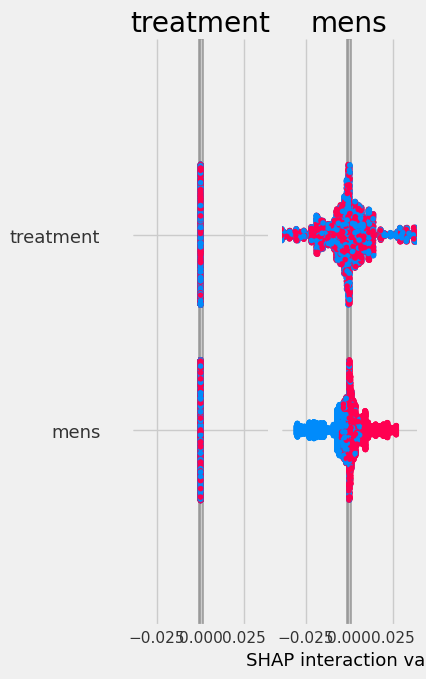

In [40]:
# Train treatment and control models
shap_treatment = shap.TreeExplainer(t_model).shap_values(X_test)
shap_control = shap.TreeExplainer(c_model).shap_values(X_test)

# Compute uplift SHAP values
uplift_shap = np.array(shap_treatment) - np.array(shap_control)

# Visualize feature importance
shap.summary_plot(uplift_shap, X_test)

## Split Train Test Treatment

In [41]:
# Split data into train/test
def split_data(df):
    X = df.drop(columns=['treatment', 'target'])
    y = df['target']
    treatment = df['treatment']
    return train_test_split(X, y, treatment, test_size=0.3)

X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

## Run Two-Model and Single-Model Approaches

In [42]:
# Model Optimization with Optuna
def optimize_model(trial, X, y, model_type):
    # Set the hyperparameters to optimize and the ranges for xgboost
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
        }
        model = XGBClassifier(**params, eval_metric='logloss')
        # Even though the eval metric for xgboost is logloss, we are evaluating the hyperparameters on maximizing AUC
    # Set the hyperparameters to optimize the ranges for random forest
    elif model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
        }
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")

    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    return np.mean(scores)

In [43]:
# Run Optuna for Both Models
def run_optuna(X, y, model_type, model_seg, n_trials=50):
    # Create a study object to maximize the AUC
    study = optuna.create_study(direction='maximize')
    # optimize the study based on the input parameters
    study.optimize(lambda trial: optimize_model(trial, X, y, model_type), n_trials=n_trials)
    print(f"Best parameters for {model_type} for {model_seg}: {study.best_params}")
    return study.best_params

In [44]:
# Train and Evaluate Models
def train_and_evaluate(X_train, X_test, y_train, y_test, params, model_type, model_seg):
    # We'll look at xgboost and random forest, this is to train the final mdoel after optuna works it's magic
    if model_type == 'xgboost':
        model = XGBClassifier(**params,  eval_metric='logloss')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")

    # Fit the model and predict probabilities on the test dataset
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Grab the AUC & LogLoss metrics for the best model
    auc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f"{model_type} AUC for {model_seg}: {auc:.4f}\n{model_type} Log Loss for {model_seg}: {logloss:.4f}")
    return model,y_pred

In [45]:
# Optimize and Train Separate Models for Two-Model Approach
def two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train):
    
    # Use function run_optuna to optimize the treatment model for xgboost and random forest adn return the optimal hyperparameters

    # Optimize treatment model for xgboost and random forest
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    params_treatment_xgboost = run_optuna(X_treatment, y_treatment, 'xgboost','treatment')
    params_treatment_randomforest = run_optuna(X_treatment, y_treatment, 'random_forest','treatment')

    # Optimize control model for xgboost and random forest
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    params_control_xgboost = run_optuna(X_control, y_control, 'xgboost','control')
    params_control_randomforest = run_optuna(X_control, y_control, 'random_forest','control')


    # Optimize single model for xgboost and random forest
    X_single_train = X_train.copy()
    X_single_train['treatment'] = t_train
    X_single_test_1 = X_test.copy()
    X_single_test_1['treatment'] = 1
    X_single_test_0 = X_test.copy()
    X_single_test_0['treatment'] = 0
    params_single_xgboost = run_optuna(X_single_train, y_train, 'xgboost','single')
    params_single_randomforest = run_optuna(X_single_train, y_train, 'random_forest','single')

    # Train final models using function train_and_evaluate
    model_treatment_xgboost,preds_treatment_xgboost = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_xgboost, 'xgboost','treatment')
    model_treatment_randomforest,preds_treatment_randomforest = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_randomforest, 'random_forest','treatment')
    model_control_xgboost,preds_control_xgboost = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_xgboost, 'xgboost','control')
    model_control_randomforest,preds_control_randomforest = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_randomforest, 'random_forest','control')
    model_single_1_xgboost,preds_single_1_xgboost = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_xgboost, 'xgboost','single_1')
    model_single_1_randomforest,preds_single_1_randomforest = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_randomforest, 'random_forest','single_1')
    model_single_0_xgboost,preds_single_0_xgboost = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_xgboost, 'xgboost','single_0')
    model_single_0_randomforest,preds_single_0_randomforest = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_randomforest, 'random_forest','single_0')

    return model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest

In [46]:
%%time
# Execute the Two-Model Approach with Optuna usng function "two_model_approach_with_optuna"
model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest = two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train)

[I 2025-01-04 10:44:52,087] A new study created in memory with name: no-name-21ed81ba-5ecd-4026-8613-9f5dca44de06
[I 2025-01-04 10:44:53,753] Trial 0 finished with value: 0.6125509944329545 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.01425077169115044, 'subsample': 0.7141546888246589, 'colsample_bytree': 0.6932385663275205, 'gamma': 4.332146939775258}. Best is trial 0 with value: 0.6125509944329545.
[I 2025-01-04 10:44:54,012] Trial 1 finished with value: 0.6152032266360404 and parameters: {'n_estimators': 97, 'max_depth': 4, 'learning_rate': 0.2736226700071032, 'subsample': 0.9777560044530441, 'colsample_bytree': 0.8495633503612521, 'gamma': 0.6446720186617033}. Best is trial 1 with value: 0.6152032266360404.
[I 2025-01-04 10:44:54,233] Trial 2 finished with value: 0.6166132480015182 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.15541061385529029, 'subsample': 0.6208556634633269, 'colsample_bytree': 0.9307327172903765, 'gamma': 2.

Best parameters for xgboost for treatment: {'n_estimators': 188, 'max_depth': 3, 'learning_rate': 0.177138800811421, 'subsample': 0.6658172101853123, 'colsample_bytree': 0.9721824063605292, 'gamma': 3.4403574126359224}


[I 2025-01-04 10:45:14,763] Trial 0 finished with value: 0.5916419651460482 and parameters: {'n_estimators': 167, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.7027834978090879}. Best is trial 0 with value: 0.5916419651460482.
[I 2025-01-04 10:45:17,298] Trial 1 finished with value: 0.594537465858921 and parameters: {'n_estimators': 190, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 0.6428895941120701}. Best is trial 1 with value: 0.594537465858921.
[I 2025-01-04 10:45:20,589] Trial 2 finished with value: 0.5942075005326676 and parameters: {'n_estimators': 243, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 0.7063080516849141}. Best is trial 1 with value: 0.594537465858921.
[I 2025-01-04 10:45:22,198] Trial 3 finished with value: 0.6112501038336228 and parameters: {'n_estimators': 144, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7439881923162771}. 

Best parameters for random_forest for treatment: {'n_estimators': 153, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.99433963533974}


[I 2025-01-04 10:46:51,607] Trial 0 finished with value: 0.6467328574152665 and parameters: {'n_estimators': 290, 'max_depth': 7, 'learning_rate': 0.014731343051728235, 'subsample': 0.9175373060508963, 'colsample_bytree': 0.9811266159841278, 'gamma': 0.8956936304927027}. Best is trial 0 with value: 0.6467328574152665.
[I 2025-01-04 10:46:51,880] Trial 1 finished with value: 0.6511665891957277 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.048197448401118406, 'subsample': 0.6743993938167436, 'colsample_bytree': 0.9210958794229218, 'gamma': 0.9451776281016494}. Best is trial 1 with value: 0.6511665891957277.
[I 2025-01-04 10:46:52,226] Trial 2 finished with value: 0.6486811493958814 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.2544716656222871, 'subsample': 0.9644301898082785, 'colsample_bytree': 0.7293353495114668, 'gamma': 3.750368450388146}. Best is trial 1 with value: 0.6511665891957277.
[I 2025-01-04 10:46:52,542] Trial 3 finishe

Best parameters for xgboost for control: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.2108864962579468, 'subsample': 0.6850497652739871, 'colsample_bytree': 0.9001035716777955, 'gamma': 3.0133894632239207}


[I 2025-01-04 10:47:11,138] Trial 0 finished with value: 0.6219374743513626 and parameters: {'n_estimators': 244, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.9847249287086662}. Best is trial 0 with value: 0.6219374743513626.
[I 2025-01-04 10:47:12,051] Trial 1 finished with value: 0.6152566143123034 and parameters: {'n_estimators': 70, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7230514244418607}. Best is trial 0 with value: 0.6219374743513626.
[I 2025-01-04 10:47:15,546] Trial 2 finished with value: 0.6191998998845408 and parameters: {'n_estimators': 299, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.6296245266573421}. Best is trial 0 with value: 0.6219374743513626.
[I 2025-01-04 10:47:16,416] Trial 3 finished with value: 0.616371451185266 and parameters: {'n_estimators': 64, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.9176290668681096}. 

Best parameters for random_forest for control: {'n_estimators': 258, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.8016930577938424}


[I 2025-01-04 10:49:07,833] Trial 0 finished with value: 0.6588661059519106 and parameters: {'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.22255349668076183, 'subsample': 0.6204973631074678, 'colsample_bytree': 0.9902472098240576, 'gamma': 4.582038558297556}. Best is trial 0 with value: 0.6588661059519106.
[I 2025-01-04 10:49:08,499] Trial 1 finished with value: 0.6593263031359146 and parameters: {'n_estimators': 292, 'max_depth': 6, 'learning_rate': 0.02258599360406236, 'subsample': 0.6349041089805698, 'colsample_bytree': 0.6594836450541891, 'gamma': 3.7849537772761583}. Best is trial 1 with value: 0.6593263031359146.
[I 2025-01-04 10:49:08,735] Trial 2 finished with value: 0.6595298027283473 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.1087935503364869, 'subsample': 0.6601795391805193, 'colsample_bytree': 0.7908162665570935, 'gamma': 3.1870198928708815}. Best is trial 2 with value: 0.6595298027283473.
[I 2025-01-04 10:49:09,212] Trial 3 finished w

Best parameters for xgboost for single: {'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.09450361758632281, 'subsample': 0.9077046951856632, 'colsample_bytree': 0.6486837837023328, 'gamma': 2.50676119793199}


[I 2025-01-04 10:49:49,258] Trial 0 finished with value: 0.632221455925762 and parameters: {'n_estimators': 295, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.7625915960112107}. Best is trial 0 with value: 0.632221455925762.
[I 2025-01-04 10:49:56,723] Trial 1 finished with value: 0.6515834445987138 and parameters: {'n_estimators': 264, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.8539798711474743}. Best is trial 1 with value: 0.6515834445987138.
[I 2025-01-04 10:50:01,304] Trial 2 finished with value: 0.6393620801091261 and parameters: {'n_estimators': 172, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6370026652854103}. Best is trial 1 with value: 0.6515834445987138.
[I 2025-01-04 10:50:09,236] Trial 3 finished with value: 0.6349115731036543 and parameters: {'n_estimators': 295, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.6861557156684738}.

Best parameters for random_forest for single: {'n_estimators': 219, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.8961749021454715}
xgboost AUC for treatment: 0.6223
xgboost Log Loss for treatment: 0.4027
random_forest AUC for treatment: 0.6203
random_forest Log Loss for treatment: 0.4017
xgboost AUC for control: 0.6241
xgboost Log Loss for control: 0.4016
random_forest AUC for control: 0.6199
random_forest Log Loss for control: 0.4025
xgboost AUC for single_1: 0.6330
xgboost Log Loss for single_1: 0.3971
random_forest AUC for single_1: 0.6246
random_forest Log Loss for single_1: 0.3994
xgboost AUC for single_0: 0.6338
xgboost Log Loss for single_0: 0.3958
random_forest AUC for single_0: 0.6312
random_forest Log Loss for single_0: 0.3974
CPU times: total: 23min 58s
Wall time: 9min 23s


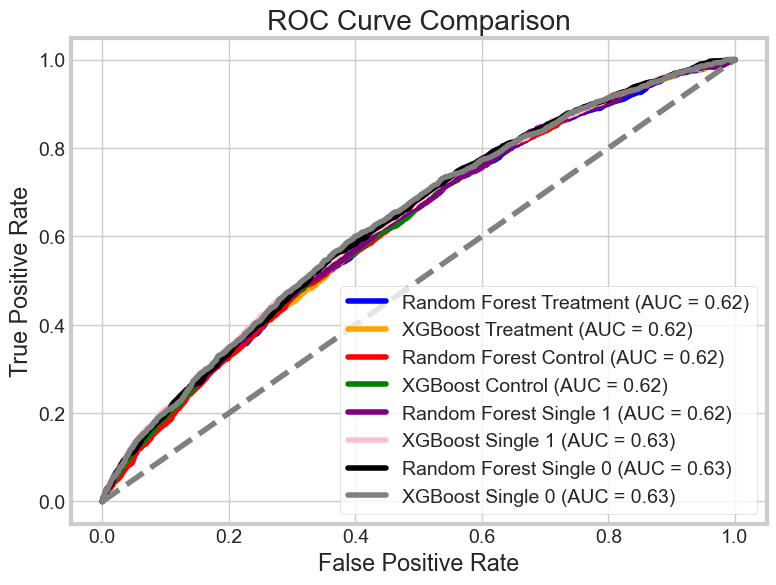

In [70]:
# Visualize AUC Curve for all models trained
# Compute ROC curve and AUC for both models
rf_trt_fpr, rf_trt_tpr, _ = roc_curve(y_test, preds_treatment_randomforest)
rf_trt_auc = auc(rf_trt_fpr, rf_trt_tpr)

xgb_trt_fpr, xgb_trt_tpr, _ = roc_curve(y_test, preds_treatment_xgboost)
xgb_trt_auc = auc(xgb_trt_fpr, xgb_trt_tpr)

rf_ctl_fpr, rf_ctl_tpr, _ = roc_curve(y_test, preds_control_randomforest)
rf_ctl_auc = auc(rf_ctl_fpr, rf_ctl_tpr)

xgb_ctl_fpr, xgb_ctl_tpr, _ = roc_curve(y_test, preds_control_xgboost)
xgb_ctl_auc = auc(xgb_ctl_fpr, xgb_ctl_tpr)

rf_s0_fpr, rf_s0_tpr, _ = roc_curve(y_test, preds_single_0_randomforest)
rf_s0_auc = auc(rf_s0_fpr, rf_s0_tpr)

xgb_s0_fpr, xgb_s0_tpr, _ = roc_curve(y_test, preds_single_0_xgboost)
xgb_s0_auc = auc(xgb_s0_fpr, xgb_s0_tpr)

rf_s1_fpr, rf_s1_tpr, _ = roc_curve(y_test, preds_single_1_randomforest)
rf_s1_auc = auc(rf_s1_fpr, rf_s1_tpr)

xgb_s1_fpr, xgb_s1_tpr, _ = roc_curve(y_test, preds_single_1_xgboost)
xgb_s1_auc = auc(xgb_s1_fpr, xgb_s1_tpr)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_trt_fpr, rf_trt_tpr, label=f"Random Forest Treatment (AUC = {rf_trt_auc:.2f})", color="blue")
plt.plot(xgb_trt_fpr, xgb_trt_tpr, label=f"XGBoost Treatment (AUC = {xgb_trt_auc:.2f})", color="orange")
plt.plot(rf_ctl_fpr, rf_ctl_tpr, label=f"Random Forest Control (AUC = {rf_ctl_auc:.2f})", color="red")
plt.plot(xgb_ctl_fpr, xgb_ctl_tpr, label=f"XGBoost Control (AUC = {xgb_ctl_auc:.2f})", color="green")
plt.plot(rf_s1_fpr, rf_s1_tpr, label=f"Random Forest Single 1 (AUC = {rf_s1_auc:.2f})", color="purple")
plt.plot(xgb_s1_fpr, xgb_s1_tpr, label=f"XGBoost Single 1 (AUC = {xgb_s1_auc:.2f})", color="pink")
plt.plot(rf_s0_fpr, rf_s0_tpr, label=f"Random Forest Single 0 (AUC = {rf_s0_auc:.2f})", color="black")
plt.plot(xgb_s0_fpr, xgb_s0_tpr, label=f"XGBoost Single 0 (AUC = {xgb_s0_auc:.2f})", color="grey")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [47]:
# Uplift scores
def create_uplift_scores(preds_treatment_xgboost,
                        preds_control_xgboost,
                        preds_treatment_randomforest,
                        preds_control_randomforest,
                        preds_single_1_xgboost,
                        preds_single_1_randomforest,
                        preds_single_0_xgboost,
                        preds_single_0_randomforest):

    uplift_two_model_rf = preds_treatment_randomforest - preds_control_randomforest

    uplift_two_model_xg = preds_treatment_xgboost - preds_control_xgboost

    uplift_single_model_xg = preds_single_1_xgboost - preds_single_0_xgboost
    
    uplift_single_model_rf = preds_single_1_randomforest - preds_single_0_randomforest
    
    return uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf

uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf = create_uplift_scores(preds_treatment_xgboost,
                                                                                                                preds_control_xgboost,
                                                                                                                preds_treatment_randomforest,
                                                                                                                preds_control_randomforest,
                                                                                                                preds_single_1_xgboost,
                                                                                                                preds_single_1_randomforest,
                                                                                                                preds_single_0_xgboost,
                                                                                                                preds_single_0_randomforest
                                                                                                                )

## Compare Two-Model Approaches and Single-Model Approaches

### sklift Qini AUC Score

In [95]:
y_test.head()

6776     0
45612    0
40775    0
37940    0
36035    0
Name: target, dtype: int64

In [98]:
uplift_two_model_rf

array([0.08647747, 0.06779813, 0.09528805, ..., 0.07904887, 0.07233004,
       0.0423028 ])

In [99]:
t_test.head()

6776     0
45612    0
40775    1
37940    0
36035    0
Name: treatment, dtype: int64

In [71]:
# Let's try sklift's qini auc score
qini_two_model_rf = qini_auc_score(y_test, uplift_two_model_rf, t_test)
qini_two_model_xg = qini_auc_score(y_test, uplift_two_model_xg, t_test)
qini_single_model_rf = qini_auc_score(y_test, uplift_single_model_rf, t_test)
qini_single_model_xg = qini_auc_score(y_test, uplift_single_model_xg, t_test)

comparison_df = pd.DataFrame({
    'Model': ['Two-Model RF', 'Two-Model XG', 'Single-Model RF', 'Single-Model XG'],
    'Qini Score': [qini_two_model_rf, qini_two_model_xg, qini_single_model_rf, qini_single_model_xg]
})
print("\n### Qini Score Comparison ###")
print(comparison_df)

# We can see initially that the XG, despite outperforming the RF on the individual models by a bit, does not outperform the random forest in the uplift model scenario
# The Two-Model RF beats out the single model RF by a little bit as well. Let's continue on.


### Qini Score Comparison ###
             Model  Qini Score
0     Two-Model RF    0.041506
1     Two-Model XG    0.026752
2  Single-Model RF    0.028018
3  Single-Model XG    0.035298


### Manual Qini Score

In [49]:
# Let's now try a manual calculation of the Qini Score
def calculate_uplift_metrics(df,uplift, n_groups=5):
    """
    Calculate common uplift model evaluation metrics.
    
    Parameters:
    y_true: array-like, actual outcome (visits)
    treatment: array-like, treatment indicator (0/1)
    uplift_scores: array-like, predicted uplift scores
    n_groups: int, number of groups for AUUC calculation
    
    Returns:
    dict with uplift metrics
    """
    # Sort by uplift scores
    df = df.sort_values(by=uplift, ascending=False)
    y_true = df['y_true'].values
    treatment = df['treatment'].values
    
    # Calculate cumulative gains
    n_samples = len(y_true)
    group_size = n_samples // n_groups
    
    gains = []
    for i in range(n_groups):
        start_idx = i * group_size
        end_idx = (i + 1) * group_size if i < n_groups - 1 else n_samples
        
        group_treat = treatment[start_idx:end_idx]
        group_outcome = y_true[start_idx:end_idx]
        
        # Calculate treatment and control response rates
        treat_rate = np.mean(group_outcome[group_treat == 1])
        ctrl_rate = np.mean(group_outcome[group_treat == 0])
        
        # Calculate uplift
        uplift = treat_rate - ctrl_rate
        gains.append(uplift)
    
    # Calculate metrics
    metrics = {
        'AUUC': np.trapz(gains) / len(gains),  # Area Under the Uplift Curve
        'Qini': np.sum(gains),  # Qini coefficient
        'top_group_uplift': gains[0],  # Uplift in highest scored group
        'uplift_by_group': gains
    }
    
    return metrics

In [50]:
# Create a dataframe with test results
results_df = pd.DataFrame({
    'y_true': y_test,               # Actual outcomes
    'treatment': t_test,            # Treatment indicators
    'uplift_tm_rf': uplift_two_model_rf,         # Uplift predictions from Random Forest
    'uplift_tm_xg': uplift_two_model_xg,        # Uplift predictions from XGBoost
    'uplift_sm_rf' : uplift_single_model_rf,
    'uplift_sm_xg' : uplift_single_model_xg
})
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg
6776,0,0,0.086477,0.113815,0.067055,0.045112
45612,0,0,0.067798,0.084487,0.067079,0.066734
40775,0,1,0.095288,0.076681,0.092817,0.065713
37940,0,0,0.072330,0.064660,0.072324,0.066043
36035,0,0,0.090069,0.087308,0.071086,0.089785


In [51]:
xg_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_xg'
   )

rf_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_rf'
   )

xg_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_xg'
   )

rf_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_rf'
   )

In [73]:
# Print the metrics in a formatted manner
print("Two-Model Random Forest Uplift Metrics")
print(f"AUUC: {rf_tm_metrics['AUUC']:.6f}")
print(f"Qini: {rf_tm_metrics['Qini']:.6f}")
print(f"Top Group Uplift: {rf_tm_metrics['top_group_uplift']:.6f}")
print("Uplift by Group:")
for i, uplift in enumerate(rf_tm_metrics['uplift_by_group'], 1):
    print(f"  Group {i}: {uplift:.6f}")
print("Two-Model XGBoost Uplift Metrics")
print(f"AUUC: {xg_tm_metrics['AUUC']:.6f}")
print(f"Qini: {xg_tm_metrics['Qini']:.6f}")
print(f"Top Group Uplift: {xg_tm_metrics['top_group_uplift']:.6f}")
print("Uplift by Group:")
for i, uplift in enumerate(xg_tm_metrics['uplift_by_group'], 1):
    print(f"  Group {i}: {uplift:.6f}")
print("Single-Model Random Forest Uplift Metrics")
print(f"AUUC: {rf_sm_metrics['AUUC']:.6f}")
print(f"Qini: {rf_sm_metrics['Qini']:.6f}")
print(f"Top Group Uplift: {rf_sm_metrics['top_group_uplift']:.6f}")
print("Uplift by Group:")
for i, uplift in enumerate(rf_sm_metrics['uplift_by_group'], 1):
    print(f"  Group {i}: {uplift:.6f}")
print("Single-Model XGBoost Uplift Metrics")
print(f"AUUC: {xg_sm_metrics['AUUC']:.6f}")
print(f"Qini: {xg_sm_metrics['Qini']:.6f}")
print(f"Top Group Uplift: {xg_sm_metrics['top_group_uplift']:.6f}")
print("Uplift by Group:")
for i, uplift in enumerate(xg_sm_metrics['uplift_by_group'], 1):
    print(f"  Group {i}: {uplift:.6f}")
# So here we are seeing the qini scores much higher and more similar.
# The XGBoost models win in this scenario
# For the AUUC, the RF wins for the TM but the XG wins for the SM

Two-Model Random Forest Uplift Metrics
AUUC: 0.046966
Qini: 0.308505
Top Group Uplift: 0.096372
Uplift by Group:
  Group 1: 0.096372
  Group 2: 0.030848
  Group 3: 0.067252
  Group 4: 0.063059
  Group 5: 0.050974
Two-Model XGBoost Uplift Metrics
AUUC: 0.052569
Qini: 0.353576
Top Group Uplift: 0.109500
Uplift by Group:
  Group 1: 0.109500
  Group 2: 0.076601
  Group 3: 0.041156
  Group 4: 0.054358
  Group 5: 0.071961
Single-Model Random Forest Uplift Metrics
AUUC: 0.049214
Qini: 0.329956
Top Group Uplift: 0.104872
Uplift by Group:
  Group 1: 0.104872
  Group 2: 0.045701
  Group 3: 0.069950
  Group 4: 0.046535
  Group 5: 0.062898
Single-Model XGBoost Uplift Metrics
AUUC: 0.044620
Qini: 0.314688
Top Group Uplift: 0.108442
Uplift by Group:
  Group 1: 0.108442
  Group 2: 0.056876
  Group 3: 0.021169
  Group 4: 0.053467
  Group 5: 0.074734


### CausalML AUUC Score

In [75]:
auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
    )
print(auuc_calc)
# Boy this a bummer, looks like the RF win in this case with the two model RF coming in first, but not much better than random, yikes.

uplift_tm_rf    0.546302
uplift_tm_xg    0.568536
uplift_sm_rf    0.542921
uplift_sm_xg    0.523380
decile_tm_rf    0.549833
target_class   -1.710286
Random          0.490513
dtype: float64


### CausalML Qini Score

In [107]:
qini = qini_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
    )
print(f"{qini}")

uplift_tm_rf    0.086336
uplift_tm_xg    0.057856
uplift_sm_rf    0.060237
uplift_sm_xg    0.074401
decile_tm_rf    0.088538
target_class   -4.822092
Random          0.000000
dtype: float64


### SKLift Plot Qini Curve

In [ ]:
# Compute Qini curve
qini_vals = qini_curve(y_test, uplift_two_model_rf, t_test)

# Generate random targeting line
random_vals = [i / len(y_test) for i in range(len(y_test))]

# Plot Qini curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(qini_vals)), qini_vals, label='Model Qini Curve')
plt.plot(range(len(random_vals)), random_vals, label='Random Targeting', linestyle='--')
plt.xlabel('Population (sorted by uplift score)')
plt.ylabel('Cumulative Uplift')
plt.title('Qini Curve')
plt.legend()
plt.grid(True)
plt.show()

### CausalML CumGain

In [115]:
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,decile_tm_rf,target_class
58446,0,1,0.206067,0.189688,0.130865,0.073083,10,2
11018,0,1,0.206067,0.189688,0.130865,0.073083,10,2
27206,0,1,0.206067,0.189688,0.130865,0.073083,10,2
35289,0,1,0.206067,0.189688,0.130865,0.073083,10,2
63890,1,1,0.206067,0.189688,0.130865,0.073083,10,3


In [119]:
# Generate cumulative gains for Qini Curve
cumgain = get_cumgain(
    df=results_df,
    outcome_col='y_test',
    treatment_col='t_test',
    treatment_effect_col='uplift_tm_rf'
)
cumgain.head()

# # Plot Qini Curve
# plt.plot(cumgain['n'], cumgain['uplift'], label='Uplift Model')
# plt.plot(cumgain['n'], cumgain['random'], linestyle='--', label='Random Targeting')
# plt.title('Qini Curve')
# plt.xlabel('Proportion Targeted')
# plt.ylabel('Cumulative Uplift')
# plt.legend()
# plt.show()

,y_true,treatment,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,decile_tm_rf,target_class,Random
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.101366,0.206067,0.157311,0.163015,0.100462,0.206067,0.065873,0.098135
2,0.155755,0.274926,0.314622,0.326029,0.200923,0.324317,0.152167,0.172672
3,0.245589,0.343603,0.471934,0.489044,0.301385,0.442568,0.265577,0.251178
4,0.349845,0.412280,0.629245,0.652058,0.401847,0.560818,0.351872,0.332255


### Decile Chart?

In [76]:
results_df = results_df.sort_values(by='uplift_tm_rf', ascending=False)

In [77]:
results_df['decile_tm_rf'] = pd.qcut(results_df['uplift_tm_rf'], 10, labels=False, duplicates='drop', ) + 1


In [78]:
def calculate_uplift(df):
    treated = df[df['treatment'] == 1]['y_true'].mean()
    control = df[df['treatment'] == 0]['y_true'].mean()
    return treated - control

# Group by decile and calculate observed uplift
decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')

C:\Users\wallj\AppData\Local\Temp\ipykernel_7120\3131367042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')


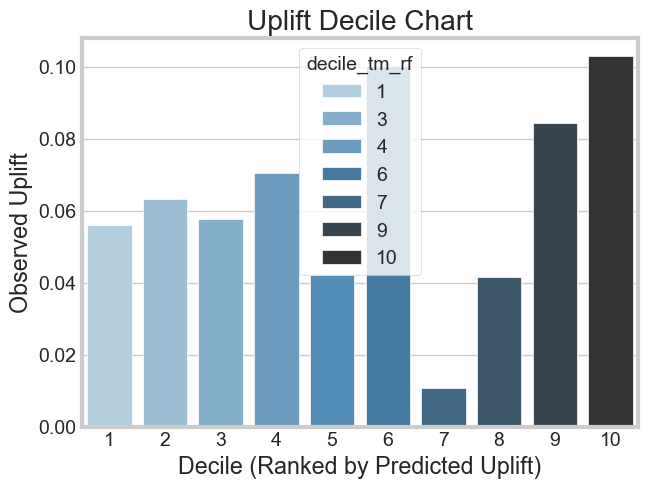

In [80]:
# Plot the observed uplift by decile
sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d', hue='decile_tm_rf')
plt.title('Uplift Decile Chart')
plt.xlabel('Decile (Ranked by Predicted Uplift)')
plt.ylabel('Observed Uplift')
plt.show()

### Fake Qini Curve

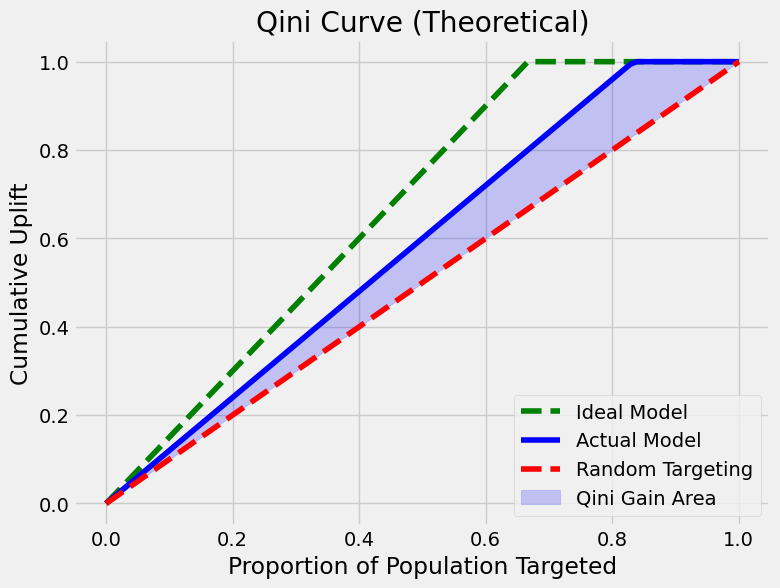

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for a Qini curve
population_targeted = np.linspace(0, 1, 100)  # Proportion of population targeted (X-axis)
random_gain = population_targeted  # Baseline (random targeting)
ideal_gain = np.minimum(population_targeted * 1.5, 1.0)  # Ideal model (optimistic upper bound)
model_gain = np.minimum(population_targeted * 1.2, 1.0)  # Typical uplift model

# Plot the Qini curve
plt.figure(figsize=(8, 6))
plt.plot(population_targeted, ideal_gain, label="Ideal Model", linestyle="--", color="green")
plt.plot(population_targeted, model_gain, label="Actual Model", color="blue")
plt.plot(population_targeted, random_gain, label="Random Targeting", linestyle="--", color="red")
plt.fill_between(population_targeted, random_gain, model_gain, color="blue", alpha=0.2, label="Qini Gain Area")

# Customize plot
plt.title("Qini Curve (Theoretical)")
plt.xlabel("Proportion of Population Targeted")
plt.ylabel("Cumulative Uplift")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Qini Curve from Kaggle

In [81]:
results_df['target_class'] = 0  # Initialize column
results_df.loc[(results_df['treatment'] == 0) & (results_df['y_true'] == 1), 'target_class'] = 1
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 0), 'target_class'] = 2
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 1), 'target_class'] = 3

In [82]:
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,decile_tm_rf,target_class
58446,0,1,0.206067,0.189688,0.130865,0.073083,10,2
11018,0,1,0.206067,0.189688,0.130865,0.073083,10,2
27206,0,1,0.206067,0.189688,0.130865,0.073083,10,2
35289,0,1,0.206067,0.189688,0.130865,0.073083,10,2
63890,1,1,0.206067,0.189688,0.130865,0.073083,10,3


In [83]:
def qini_rank(uplift: pd.DataFrame, uplift_score: str) -> pd.DataFrame:
    """Rank the data by the uplift score for a specific model."""
    ranked = uplift[['target_class', uplift_score]].copy()
    ranked.rename(columns={uplift_score: 'uplift_score'}, inplace=True)

    # Add proportion
    ranked['n'] = ranked['uplift_score'].rank(pct=True, ascending=False)

    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

In [84]:
def qini_eval(ranked: pd.DataFrame) -> pd.DataFrame:
    """Evaluate the uplift value with the QINI criterion."""
    uplift_model = ranked.copy()
    random_model = ranked.copy()

    # Calculate cumulative gains for treatment and control groups
    C = sum(ranked['target_class'] <= 1)  # Total control group
    T = sum(ranked['target_class'] >= 2)  # Total treatment group
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1, 'cr'] = 1
    ranked.loc[ranked.target_class == 3, 'tr'] = 1
    ranked['cr/c'] = ranked['cr'].cumsum() / C
    ranked['tr/t'] = ranked['tr'].cumsum() / T

    # Calculate uplift for the model and random targeting
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'], 5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1], 5)

    # Add q0 for initial point
    q0 = pd.DataFrame({'n': [0], 'uplift': [0], 'target_class': [None]})
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop=True)
    random_model = pd.concat([q0, random_model]).reset_index(drop=True)

    # Add model names and combine
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop=True)
    return merged


In [85]:
def qini_plot(merged: pd.DataFrame):
    """Plot QINI curves for multiple models."""
    sns.set_style('whitegrid')

    # Plot the data
    ax = sns.lineplot(
        x='n', y='uplift', hue='model', data=merged, style='model', palette='Set2'
    )

    # Customize plot settings
    plt.xlabel('Proportion Targeted', fontsize=15)
    plt.ylabel('Uplift', fontsize=15)
    plt.title('Qini Curves for Multiple Models', fontsize=16)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    plt.grid(True)
    plt.show()
    return ax

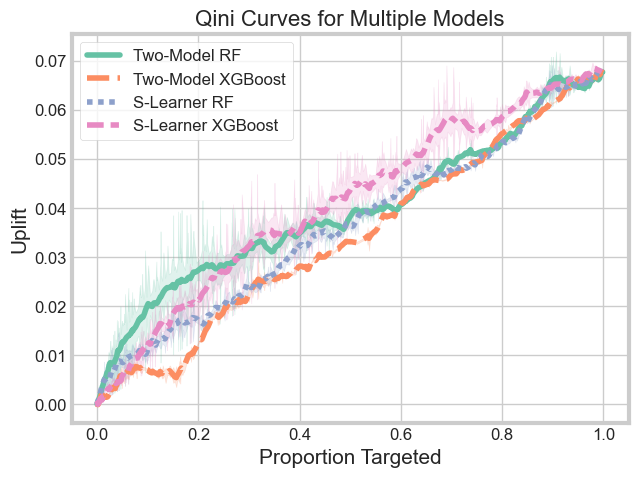

<Axes: title={'center': 'Qini Curves for Multiple Models'}, xlabel='Proportion Targeted', ylabel='Uplift'>

In [86]:
# Combine QINI results for all models
merged_results = pd.DataFrame()

# List of uplift columns for different models
uplift_columns = ['uplift_tm_rf', 'uplift_tm_xg', 'uplift_sm_rf', 'uplift_sm_xg']
model_names = ['Two-Model RF', 'Two-Model XGBoost', 'S-Learner RF', 'S-Learner XGBoost']

for uplift_score, model_name in zip(uplift_columns, model_names):
    ranked = qini_rank(results_df, uplift_score)
    merged = qini_eval(ranked)
    merged['model'] = model_name  # Add model name for identification
    merged_results = pd.concat([merged_results, merged], ignore_index=True)

# Plot all QINI curves
qini_plot(merged_results)

***